In [4]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.stattools import acf, adfuller, kpss, pacf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from seasonal_override import seasonal_decompose
import itertools

import datetime
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import csv

def open_data(path=None):
    time_series = []
    text_file = open(path, "r")
    lines = text_file.read().split('\n')
    for element in lines:
        row_item = element.split(',')
        time_series.append(row_item)
    return time_series


def parse_into_dataframe(data):
    # btdubs whitespace at parts of your file fuck you just sayin
    data_frame = pd.DataFrame(np.array(data[1:]), columns=[data[0][0], data[0][1]])
    data_frame['Date'] = pd.to_datetime(data_frame['Date'], format='%Y-%m-%d')
    data_frame['Value'] = pd.to_numeric(data_frame['Value'])
    data_frame.index = pd.DatetimeIndex(data=data_frame['Date'])
    data_frame = data_frame.sort_index(axis=0, ascending=True)
    # data_frame = data_frame.drop(columns='Date')
    return data_frame


def plot_raw_data(time_series_raw, name=None):
    plt.plot(time_series_raw['Date'],  time_series_raw['Value'])
    plt.xlabel("Date")
    plt.ylabel("Price")
#     plt.savefig(name)
    plt.show()


def plot_acf_data(time_series_raw, nlags=50, name=None):
    plt.bar(np.arange(0, nlags+1), acf(time_series_raw['Value'], nlags=nlags), width=0.5)
    plt.xlabel("Lag")
    plt.ylabel("ACF")
#     plt.savefig(name)
    plt.show()


def plot_pacf_data(time_series_raw, nlags=50, name=None):
    plt.bar(np.arange(0, nlags+1), pacf(time_series_raw['Value'], nlags=nlags), width=0.5)
    plt.xlabel("Lag")
    plt.ylabel("PACF")
#     plt.savefig(name)
    plt.show()


def plot_seasonal_decompose(time_series_raw, seasonal=False):
    time_series_raw = time_series_raw.drop(columns='Date')
    decomposition = seasonal_decompose(time_series_raw, model='additive')
    if seasonal:
        plt.plot(decomposition.seasonal, label='Freq: {}'.format(decomposition.freq))
        plt.legend(loc='upper left')
    else:
        decomposition.plot()
    plt.show()


# https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/
def ar_model(time_series_raw, time_lag=10, max_lag=1, y_label='', name=None, title="AR Model"):
    train_length = len(time_series_raw['Value']) - time_lag
    y_hat = pd.DataFrame([], columns=['Value'])
    for train_index in range(0, train_length):
        train, test = time_series_raw['Value'].iloc[train_index:train_index+time_lag], time_series_raw['Value'].iloc[train_index+time_lag]
        start_date_train = time_series_raw['Date'].iloc[train_index]
        end_date_train = time_series_raw['Date'].iloc[train_index+time_lag-1]
        predict_test = time_series_raw['Date'].iloc[train_index+time_lag]
        model = AR(train, dates=pd.date_range(start=start_date_train, end=end_date_train, freq='M'))
        model_fit = model.fit(maxlag=max_lag)
        predictions = model_fit.predict(start=predict_test, end=predict_test, dynamic=True)
        predictions = pd.DataFrame(predictions[0], columns=['Value'],
                                   index=pd.DatetimeIndex(data=predictions.index.date))
        y_hat = y_hat.append(predictions)
    # Drop the first time_lag+1 rows
    time_series_raw = time_series_raw[time_lag:]
    # MSE
    diff_score = time_series_raw['Value'].subtract(y_hat['Value'], axis=0)
    diff_score = diff_score.dropna()**2
    mse = diff_score.sum()
    print("MSE: {}".format(mse))
    plt.plot(time_series_raw.index, time_series_raw['Value'], label='Real Values')
    plt.plot(y_hat.index, y_hat['Value'], label='Predicted Values')
    plt.legend(loc='upper left')
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(y_label)
#     plt.savefig(name)
    plt.show()


def arma_model(time_series_raw, coefficients=None, time_lag=10, max_lag=1, y_label=''):
    train_length = len(time_series_raw['Value']) - time_lag
    y_hat = pd.DataFrame([], columns=['Value'])
    for train_index in range(0, train_length):
        train, test = time_series_raw['Value'].iloc[train_index:train_index+time_lag], time_series_raw['Value'].iloc[train_index+time_lag]
        start_date_train = time_series_raw['Date'].iloc[train_index]
        end_date_train = time_series_raw['Date'].iloc[train_index+time_lag-1]
        predict_test = time_series_raw['Date'].iloc[train_index+time_lag]
        model = ARMA(train, [coefficients[0], coefficients[1]], dates=pd.date_range(start=start_date_train, end=end_date_train, freq='M'))
        model_fit = model.fit(maxlag=max_lag, disp=-1)
        predictions = model_fit.predict(start=predict_test, end=predict_test, dynamic=True)
        predictions = pd.DataFrame(predictions[0], columns=['Value'],
                                   index=pd.DatetimeIndex(data=predictions.index.date))
        y_hat = y_hat.append(predictions)
    # Drop the first time_lag+1 rows
    time_series_raw = time_series_raw[time_lag:]
    # MSE
    diff_score = time_series_raw['Value'].subtract(y_hat['Value'], axis=0)
    diff_score = diff_score.dropna()**2
    mse = diff_score.sum()
    print("MSE: {}".format(mse))
    plt.plot(y_hat.index, y_hat['Value'], label='Predicted Values')
    plt.plot(time_series_raw.index, time_series_raw['Value'], label='Real Values')
    plt.legend(loc='upper left')
    plt.title("ARMA Model")
    plt.xlabel("Date")
    plt.ylabel(y_label)
    plt.show()


def arima_model(time_series_raw):
    p = d = q = range(0, 3)
    pdq = list(itertools.product(p, d, q))
    # We are going to brute force an arimax here
    try:
        f = open('ARIMA_brute_force_data.txt', 'r')
        print('File exists')
    except FileNotFoundError:
        f = open('ARIMA_brute_force_data.txt', 'w+')

        for param in pdq:
            try:
                mod = ARIMA(time_series_raw['Value'], order=param)
                results = mod.fit(disp=-1)
                f.write('ARIMA{}\t{}\n'.format(param, results.aic))
                print('ARIMA{}\t{}'.format(param, results.aic))
            except Exception:
                f.write('ARIMA{}\t{}\n'.format(param, '999999999999999999'))
                continue
        f.close()
        print('Done')


def sort_pdf_arima_txt():
    df = pd.DataFrame([], columns=['ARIMA_Stats', 'AIC'])
    with open('ARIMA_brute_force_data.txt', 'r') as f:
        content = csv.reader(f, delimiter='\t')
        for line in content:
            d = {'ARIMA_Stats': [str(line[0])], 'AIC': [float(line[1])]}
            df = df.append(pd.DataFrame(data=d, columns=['ARIMA_Stats', 'AIC']))
    df = df.sort_values(by=['AIC'])
    try:
        f = open('ARIMA_brute_force_data_sorted.txt', 'r')
        print('File exists')
    except FileNotFoundError:
        f = open('ARIMA_brute_force_data_sorted.txt', 'w+')
        for index, row in df.iterrows():
            f.write('{}\t{}\n'.format(row['ARIMA_Stats'], row['AIC']))
        f.close()

# Dickey fuller test to test if time series is stationary
# https://machinelearningmastery.com/time-series-data-stationary-python/
# https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/
# Null hypothesis is that this series is not stationary
# p <= 0.05 indicates that this series is stationary
def dickey(time_series_raw, max_lag=None):
    result = adfuller(time_series_raw['Value'], maxlag=max_lag)
    dickey_output = pd.Series(result[0:3], index=['Test Statistic', 'p-value', 'Lags Used'])
    print('Results of Dickey Test')
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print (dickey_output)


# Null hypothesis is that the time series is stationary
# p <= 0.5 indicates that the series is not stationary
def kpss_test(time_series_raw, max_lag=None):
    print('Results of KPSS Test:')
    kpsstest = kpss(time_series_raw['Value'], lags=max_lag)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic', 'p-value', 'Lags Used'])
    for key, value in kpsstest[3].items():
        kpss_output['Critical Value (%s)' % key] = value
    print(kpss_output)


def diff_series(time_series_raw, diff=1):
    values = time_series_raw['Value']
    for d in range(1, diff+1):
        values = values.shift(1) - values
        values = values.dropna()
    values = values.to_frame()
    values.iloc[1].name = 'Value'
    return values


def no_diff_series(time_series_raw, dickey_toggle=False, kpss_toggle=False, name=None, max_lag=None):
    if dickey_toggle:
        dickey(time_series_raw, max_lag=max_lag)
    if kpss_toggle:
        kpss_test(time_series_raw, max_lag=max_lag)
    if name:
        plot_acf_data(time_series_raw, name=name)
    return time_series_raw


def diff_one_series(time_series_raw, dickey_toggle=False, kpss_toggle=False, name=None, max_lag=None):
    shift_one = diff_series(time_series_raw)
    if dickey_toggle:
        dickey(shift_one, max_lag=max_lag)
    if kpss_toggle:
        kpss_test(shift_one, max_lag=max_lag)
    shift_one['Date'] = shift_one.index
    if name:
        plot_acf_data(shift_one, name=name)
    return shift_one


def pdf_brute_force_arimax(time_series_raw):
    p = d = q = range(0, 3)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    # We are going to brute force an arimax here
    try:
        f = open('ARIMAX_brute_force_data.txt', 'r')
        print('File exists')
    except FileNotFoundError:
        f = open('ARIMAX_brute_force_data.txt', 'w+')

        for param in pdq:
            for param_seasonal in seasonal_pdq:
                try:
                    mod = sm.tsa.statespace.SARIMAX(time_series_raw['Value'],
                                                    order=param,
                                                    seasonal_order=param_seasonal,
                                                    enforce_stationarity=False,
                                                    enforce_invertibility=False)
                    results = mod.fit(disp=-1)
                    f.write('ARIMA{}x{}\t{}'.format(param, param_seasonal, results.aic))
                    f.write('\n')
                    print('ARIMA{}x{}\t{}'.format(param, param_seasonal, results.aic))
                except Exception:
                    f.write('ARIMA{}x{}\t{}'.format(param, param_seasonal, '999999999999999999'))
                    continue
        f.close()
        print('Done')


def sort_pdf_arimax_txt():
    df = pd.DataFrame([], columns=['ARIMA_Stats', 'AIC'])
    with open('ARIMAX_brute_force_data.txt', 'r') as f:
        content = csv.reader(f, delimiter='\t')
        for line in content:
            d = {'ARIMA_Stats': [str(line[0])], 'AIC': [float(line[1])]}
            df = df.append(pd.DataFrame(data=d, columns=['ARIMA_Stats', 'AIC']))
    df = df.sort_values(by=['AIC'])
    try:
        f = open('ARIMAX_brute_force_data_sorted.txt', 'r')
        print('File exists')
    except FileNotFoundError:
        f = open('ARIMAX_brute_force_data_sorted.txt', 'w+')
        for index, row in df.iterrows():
            f.write('{}\t{}\n'.format(row['ARIMA_Stats'], row['AIC']))
        f.close()

time_series_hog = open_data(path="{}".format('./ODA-PPORK_USD_LEAN_HOG_1980_2017.csv'))
time_series_soybean = open_data(path="{}".format('./ODA-PSOYB_USD_SOYBEAN_PRICE_1980_2017.csv'))
time_series_hog = parse_into_dataframe(time_series_hog)
time_series_soybean = parse_into_dataframe(time_series_soybean)

Raw Data


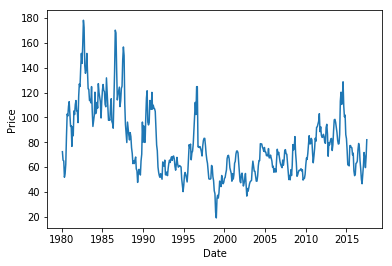

AR(0)
MSE: 106507.704959


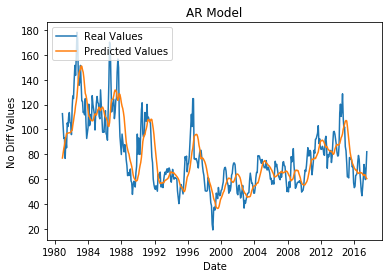

ACF AR(0)


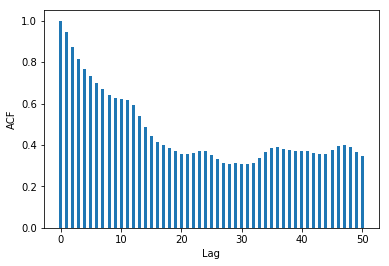

PACF AR(0)


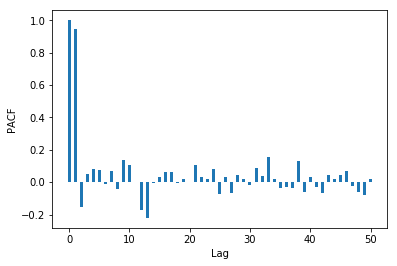

In [8]:
print('Raw Data')
plot_raw_data(no_diff_series_hog)
print('AR(0)')
ar_model(no_diff_series_hog, max_lag=0,  y_label='No Diff Values', name='1_ar_no_diff_series')
print('ACF AR(0)')
plot_acf_data(no_diff_series_hog, name='1_ACF_diff_0')
print('PACF AR(0)')
plot_pacf_data(no_diff_series_hog, name='1_PACF_diff_0')


Raw Data Diff 1


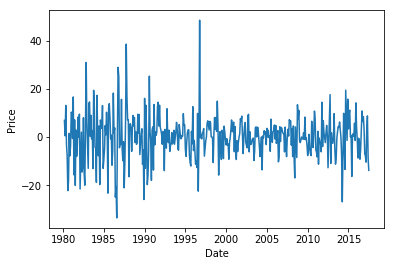

AR(1)
MSE: 50657.98725681672


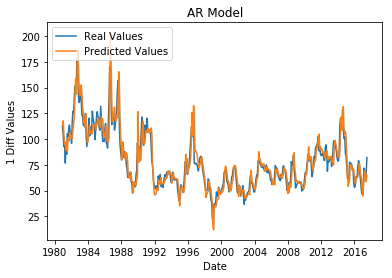

ACF AR(1)


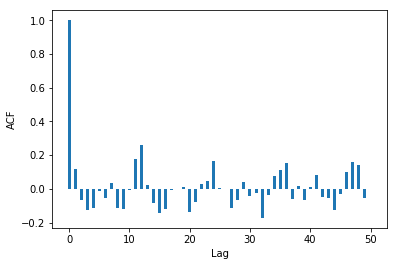

PACF AR(1)


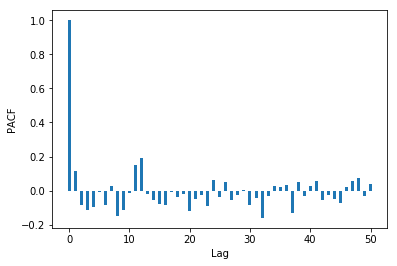

In [9]:
print('Raw Data Diff 1')
plot_raw_data(shift_one_series_hog)
print('AR(1)')
ar_model(no_diff_series_hog, max_lag=1,  y_label='1 Diff Values', name='1_ar_no_diff_series')
print('ACF AR(1)')
plot_acf_data(shift_one_series_hog, name='1_ACF_diff_0')
print('PACF AR(1)')
plot_pacf_data(shift_one_series_hog, name='1_PACF_diff_1')
